# Customer churn

Customers began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have found that it is cheaper to retain current customers than to attract new ones.
It is necessary to predict whether the client will leave the bank in the near future or not. You are presented with historical data on the behavior of customers and the termination of contracts with the bank.
Build a model with an extremely large value of the F1-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the F1 measure on the test sample yourself.
Additionally, measure the AUC-ROC, compare its value with the F1-measure.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Content**
1. Data preparation
2. Research of the problem
3. Fighting the imbalance
4. Testing the model

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Columns such as `RowNumber', `CustomerID', `Surname` are unique for each of the clients, therefore they can't be used as features, so we will remove them from the dataframe

In [5]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

The `Geography` and `Gender` columns are categorical data columns, let's use the one hot encoding technique. In order to avoid multicollinearity, set drop_first = True in the get_dummies function

In [6]:
df = pd.get_dummies(df, drop_first = True)

Gaps in the `Tenure` column are not a problem for models such as a decision tree and a random forest, however, for logistic regression, gaps are a problem, so either they can be filled with a median, but then there will be a fairly large outlier, since the number of gaps - 9% of the entire dataset, or throw it out of the training sample, however, it is possible that these clients have some special characteristics on which they should be trained, you can also fill in the gaps with random values in proportions, as in the remaining dataset, so first we will train a model of a decision tree, random forest and logistic regression with default hyperparameters for all 3 variants and let's look at the quality metrics of the models on the validation sample, based on this we will conclude about the method of working with omissions

In [7]:
df_without_missed_values = df.dropna()
df_fill_median = df.fillna(df.dropna()['Tenure'].median())
df_fill_random = df.copy()
rand = df_without_missed_values['Tenure'].sample(df['Tenure'].isna().sum(), random_state = 122333).values
df_fill_random['Tenure'] = df_fill_random['Tenure'].fillna(dict(zip(df[df['Tenure'].isna()].index, rand)))
dataframes = [df_without_missed_values, df_fill_median, df_fill_random]
models = [DecisionTreeClassifier(random_state=122333), RandomForestClassifier(random_state = 122333), LogisticRegression()]

In [8]:
def fit_and_get_score (data, model):
    features = data.drop('Exited', axis = 1)
    target = data['Exited']
    features_train, features_valid, target_train, target_valid = train_test_split(
                    features,target,test_size=0.25,random_state=122333)
    model.fit(features_train, target_train)
    return f1_score(target_valid, model.predict(features_valid))
results = pd.DataFrame(index = ['missed', 'median', 'random'], columns = ['DecisionTree', 'RandomForest', 'LogisticRegression'])
for ind in results.index:
    for col in results.columns:
        results.loc[ind,col] = fit_and_get_score(dataframes[list(results.index).index(ind)], models[list(results.columns).index(col)] )
results

,DecisionTree,RandomForest,LogisticRegression
missed,0.466454,0.579017,0.088531
median,0.504249,0.587814,0.090435
random,0.513966,0.573141,0.090592


As we can see, discarding these objects with a missing value gives a worse result than the proposed fillings, probably because the training sample turned out to be smaller, median or random filling is not much different, there is no such thing that one filling method is consistently better than the other, so we will choose random filling

In [9]:
df = df_fill_random

Let's look at the correlation of features

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,0.000596,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.014640,0.028308,-0.030680,-0.007201
Tenure,0.000596,-0.014640,1.000000,-0.009183,0.009021,0.012410
Balance,0.006268,0.028308,-0.009183,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.009021,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.012410,0.012797,0.014204,1.000000


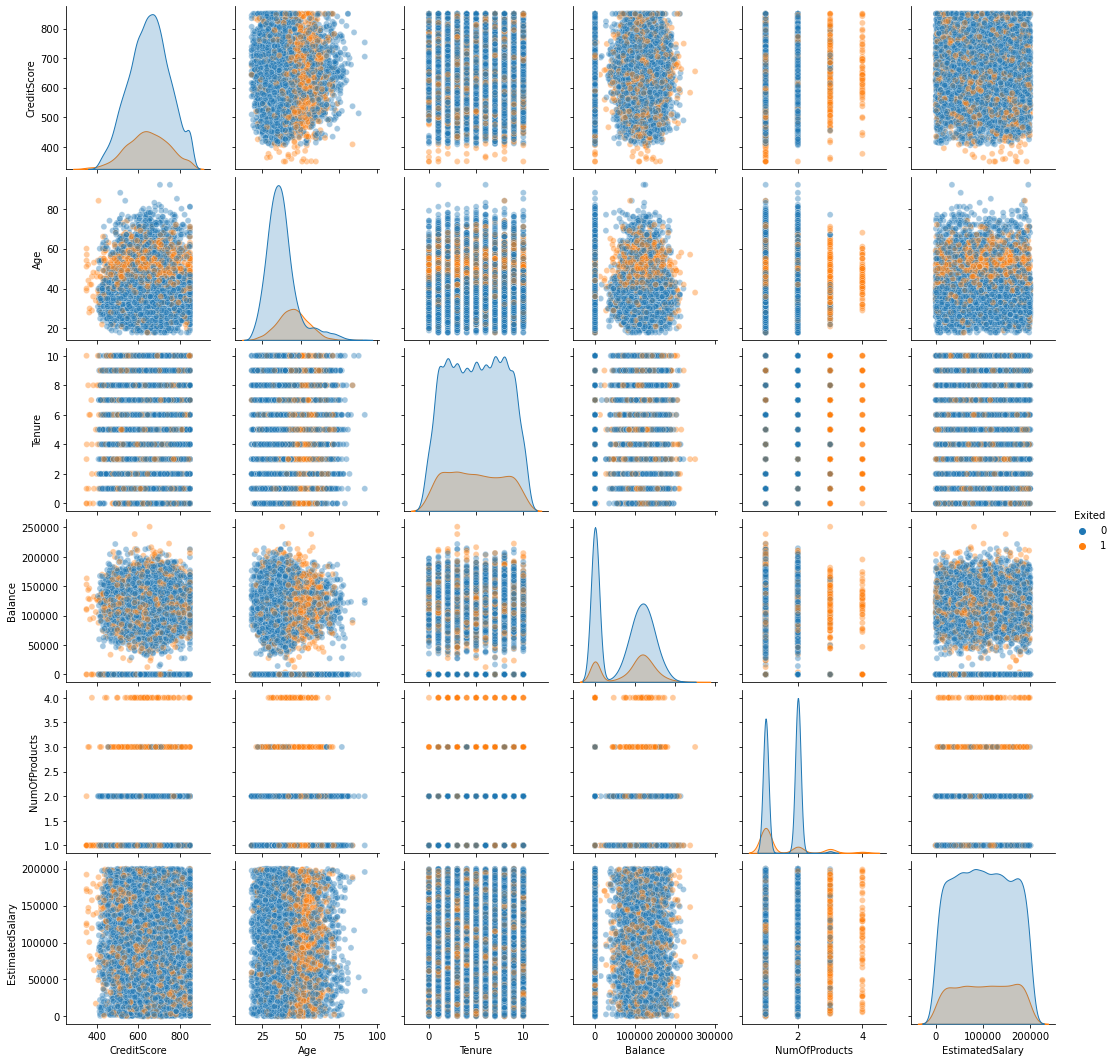

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']
sns.pairplot(df[numeric + ['Exited']], hue = 'Exited', plot_kws={'alpha' : 0.4})
df[numeric].corr()

As we can see, there is no strong relationship between the signs, but there are a couple of patterns: zero balance is more common among customers who have not left, a large number of used products are typical for departed customers.

Let's divide the sample into training, validation and testing in relation to 3:1:1

In [11]:
features = df.drop('Exited', axis = 1)
target = df['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state=122333)

Since numerical features are highly varying in magnitudes, we apply scaling to such features as `CreditScore`, `Age`, `Tenure`,`Balance`, `NumOfProducts`, `EstimatedSalary` 

In [12]:
scaler = StandardScaler()
scaler.fit(features_train.loc[:,numeric])
features_train.loc[:,numeric] = scaler.transform(features_train.loc[:,numeric])
features_test.loc[:,numeric] = scaler.transform(features_test.loc[:,numeric])

## Task research

Let's consider the models of the decision tree, random forest and logistic regression to solve the problem, select the best hyperparameters and train the models

In [13]:
def upsampling (features_for_upsampling, target_for_upsampling, ratio):
    features_train_upsampled = pd.concat([features_for_upsampling[target_for_upsampling == 0]] + [features_for_upsampling[target_for_upsampling == 1]] * ratio)
    target_train_upsampled = pd.concat([target_for_upsampling[target_for_upsampling == 0]] + [target_for_upsampling[target_for_upsampling == 1]] * ratio)
    return shuffle(features_train_upsampled, target_train_upsampled, random_state = 122333)

In [14]:
def downsampling(features_for_downsampling, target_for_downsampling, number):
    features_train_downsampling = pd.concat([features_for_downsampling[target_for_downsampling == 0].sample(n = number, random_state = 122333),
                                          features_for_downsampling[target_for_downsampling == 1]])
    target_train_downsampling = pd.concat([target_for_downsampling[target_for_downsampling == 0].sample(n = number,
                                         random_state = 122333), target_for_downsampling[target_for_downsampling == 1]])
    return shuffle(features_train_downsampling, target_train_downsampling, random_state = 122333)

In [106]:
def score_for_sampling(model, features_for_score, target_for_score, upsample):
    cv = KFold(n_splits=5)
    metrics = {'F1' : 0, 'Roc_auc' : 0, 'Accuracy' : 0, 'Precision' : 0, 'Recall' : 0}
    for train_index, valid_index in cv.split(features_for_score, target_for_score):
        features_train_temp, target_train_temp = features_for_score.iloc[train_index], target_for_score.iloc[train_index]
        features_valid_temp, target_valid_temp = features_for_score.iloc[valid_index], target_for_score.iloc[valid_index]
        if(upsample):
            features_train_temp, target_train_temp = upsampling(features_train_temp,target_train_temp,
                                 len(target_for_score[target_for_score == 0]) // len(target_for_score[target_for_score == 1]))
        else:
            features_train_temp, target_train_temp = downsampling(features_train_temp,target_train_temp,
                                 len(target_train_temp[target_train_temp == 1]))
        model.fit(features_train_temp,target_train_temp)
        metrics['F1'] += f1_score(target_valid_temp, model.predict(features_valid_temp))
        metrics['Roc_auc'] +=  roc_auc_score(target_valid_temp, model.predict_proba(features_valid_temp)[:,1])
        metrics['Accuracy'] += accuracy_score(target_valid_temp, model.predict(features_valid_temp))
        metrics['Precision'] += precision_score(target_valid_temp, model.predict(features_valid_temp))
        metrics['Recall'] += recall_score(target_valid_temp, model.predict(features_valid_temp))
    metrics = {key: metrics[key]/5 for key in metrics}
    return metrics

In [17]:
def get_score_hyperparameters (model, features_for_score, target_for_score, upsampling = False, downsampling = False) :
    if(upsampling):
        return score_for_sampling(model, features_for_score, target_for_score,True)
    if(downsampling):
        return score_for_sampling(model, features_for_score, target_for_score,False)
    metrics = {}
    metrics['F1'] = np.mean(cross_val_score(model, features_for_score, target_for_score, scoring='f1'))
    metrics['Roc_auc'] =  np.mean(cross_val_score(model, features_for_score, target_for_score, scoring='roc_auc'))
    metrics['Accuracy'] = np.mean(cross_val_score(model, features_for_score, target_for_score, scoring='accuracy'))
    metrics['Precision'] = np.mean(cross_val_score(model, features_for_score, target_for_score, scoring='precision'))
    metrics['Recall'] = np.mean(cross_val_score(model, features_for_score, target_for_score, scoring='recall'))
    return metrics

In [18]:
def roc_curve_plot (target_for_plot, predicted_for_plot, improve = False, FPR_score = 0.1):
    fpr,tpr, threshold = roc_curve(target_for_plot, predicted_for_plot)
    plt.plot(fpr,tpr)
    point = np.argmin([abs(i-0.5) for i in threshold])
    plt.plot(fpr[point], tpr[point], color = 'red', marker = 'o')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-curve')
    
    if(improve):
        best_point = np.argmin([abs(i-FPR_score) for i in fpr])
        plt.plot(fpr[best_point], tpr[best_point], color = 'green', marker = 'o')
        print('TPR = ',tpr[best_point])
        print('FPR = ',fpr[best_point])
        print('Threshold = ', threshold[best_point])
        return threshold[best_point]
    else:
        print('TPR = ',tpr[point])
        print('FPR = ',fpr[point])

In [19]:
models_and_metrics = pd.DataFrame(index=['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression'], columns = ['F1','Roc_auc','Accuracy','Precision','Recall'])

### 1. Decision tree

Let's select the hyperparameters that give the largest coefficient of the F1 metric, for this we will use GridSearchCV

In [20]:
tree_parameters = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(4,25,3),
    'min_samples_split' : range(2,40,3),
    'min_samples_leaf' : range(2,20,2)
}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state = 122333),tree_parameters,cv = 5, scoring = 'f1')
grid_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=122333),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 25, 3),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(2, 40, 3)},
             scoring='f1')

In [21]:
grid_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 38}

Now let's look at the results of the decision tree model using pruning on a full tree without early stopping to avoid overfitting, first we will select the best alpha coefficient using the F1 metric

In [22]:
parameters = {'ccp_alpha' : np.arange(0,0.02,0.0005)}
grid_tree_ccp = GridSearchCV(DecisionTreeClassifier(random_state = 122333), parameters, scoring = 'f1')
grid_tree_ccp.fit(features_train,target_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=122333),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195])},
             scoring='f1')

In [23]:
grid_tree_ccp.best_params_

{'ccp_alpha': 0.001}

Let's look at the result of the model with the best ccp_alpha using cross-validation

In [25]:
print(get_score_hyperparameters(DecisionTreeClassifier(**grid_tree_ccp.best_params_, random_state = 122333), features_train,target_train))

{'F1': 0.5682275958886751, 'Roc_auc': 0.8291988007847859, 'Accuracy': 0.8596, 'Precision': 0.7535494410578738, 'Recall': 0.45746916796942844}


Pruning on the decision tree in our case gives very good results, so let's try to add it as a hyperparameter and look for the best combination based on the previously selected combination of the best hyperparameters

In [26]:
new_params = {
    'ccp_alpha' : np.arange(0,0.003,0.0005),
    'max_depth' : range(5,12),
    'min_samples_split' : range(32,40),
    'min_samples_leaf' : range(2,12)
}
grid_pruning_tree = GridSearchCV(DecisionTreeClassifier(random_state = 122333),new_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_pruning_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
                         'max_depth': range(5, 12),
                         'min_samples_leaf': range(2, 12),
                         'min_samples_split': range(32, 40)},
             scoring='f1')

In [27]:
grid_pruning_tree.best_params_

{'ccp_alpha': 0.0005,
 'max_depth': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 38}

In [28]:
metrics_ = get_score_hyperparameters(DecisionTreeClassifier(**grid_pruning_tree.best_params_, random_state= 122333), features_train, target_train)
print(metrics_)

{'F1': 0.5722928256720362, 'Roc_auc': 0.8377568619933656, 'Accuracy': 0.8544, 'Precision': 0.7042937004352847, 'Recall': 0.4831704881014417}


In [29]:
best_tree_params = grid_pruning_tree.best_params_
best_tree_model = grid_pruning_tree.best_estimator_
models_and_metrics.loc['DecisionTreeClassifier', :] = metrics_

### 2. Random Forest

Let's select the hyperparameters that give the highest value of the F1 metric, first select the hyperparameters 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf' with a small number of trees in order to quickly select the best combination, and then select 'n_estimators' and 'ccp_alpha'

In [30]:
forest_parameters = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(5,20,3),
    'min_samples_split' : range(10,40,4),
    'min_samples_leaf' : range(2,20,2),
    'n_estimators' : [20]
}
grid_forest = GridSearchCV(RandomForestClassifier(random_state = 122333), forest_parameters, scoring = 'f1', n_jobs=-1)
grid_forest.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=122333), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 20, 3),
                         'min_samples_leaf': range(2, 20, 2),
                         'min_samples_split': range(10, 40, 4),
                         'n_estimators': [20]},
             scoring='f1')

In [31]:
grid_forest.best_params_

{'criterion': 'gini',
 'max_depth': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 20}

Now let's select the ccp_alpha parameter

In [32]:
forest_parameters = {
    'criterion' : ['gini'],
    'max_depth' : range(15,20),
    'min_samples_split' : range(10,22,4),
    'min_samples_leaf' : range(2,8,2),
    'ccp_alpha' : np.arange(0,0.002,0.0005),
    'n_estimators' : [20]
}
grid_forest_ccp = GridSearchCV(RandomForestClassifier(random_state = 122333), forest_parameters, scoring = 'f1', n_jobs = -1)
grid_forest_ccp.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=122333), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015]),
                         'criterion': ['gini'], 'max_depth': range(15, 20),
                         'min_samples_leaf': range(2, 8, 2),
                         'min_samples_split': range(10, 22, 4),
                         'n_estimators': [20]},
             scoring='f1')

In [33]:
best_params = grid_forest_ccp.best_params_
print(best_params)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


And select the parameter n_estimators

In [34]:
other_parameters = {key:[best_params[key]] for key in best_params}
other_parameters['n_estimators'] = range(50,150,10)
grid_forest = GridSearchCV(RandomForestClassifier(random_state = 122333), other_parameters, scoring = 'f1', n_jobs = -1)
grid_forest.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=122333), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0], 'criterion': ['gini'],
                         'max_depth': [17], 'min_samples_leaf': [2],
                         'min_samples_split': [10],
                         'n_estimators': range(50, 150, 10)},
             scoring='f1')

In [35]:
best_params = grid_forest.best_params_
best_params

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_depth': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 80}

Let's look at the metrics of the resulting model

In [36]:
metrics_ = get_score_hyperparameters(RandomForestClassifier(**grid_forest.best_params_, random_state=122333), features_train, target_train)
print(metrics_)

{'F1': 0.5679923096709445, 'Roc_auc': 0.8498046158350296, 'Accuracy': 0.8629333333333336, 'Precision': 0.7831554006467641, 'Recall': 0.44562706270627056}


In [37]:
best_forest_params = best_params
best_forest_model = grid_forest.best_estimator_
models_and_metrics.loc['RandomForestClassifier', :] = metrics_

### 3. Logistic Regression

Let's select the best hyperparameters for this model

In [38]:
logistic_parameters = {
    'penalty' : ['l1','l2'],
    'max_iter' : range(50,150,10),
    'solver' : ['liblinear']
}
grid_logistic = GridSearchCV(LogisticRegression(random_state = 122333), logistic_parameters, scoring = 'f1', n_jobs=-1)
grid_logistic.fit(features_train, target_train)

GridSearchCV(estimator=LogisticRegression(random_state=122333), n_jobs=-1,
             param_grid={'max_iter': range(50, 150, 10),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

In [39]:
grid_logistic.best_params_

{'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}

In [40]:
metrics_ = get_score_hyperparameters(LogisticRegression(**grid_logistic.best_params_), features_train, target_train)
print(metrics_)

{'F1': 0.29633591730738934, 'Roc_auc': 0.7636083531881701, 'Accuracy': 0.8102666666666666, 'Precision': 0.5922576145082539, 'Recall': 0.1977657634184471}


In [41]:
best_logistic_params = grid_logistic.best_params_
best_logistic_model = grid_logistic.best_estimator_
models_and_metrics.loc['LogisticRegression', :] = metrics_

## Fighting the imbalance

Let's look at the number of Class 1 and 0 clients

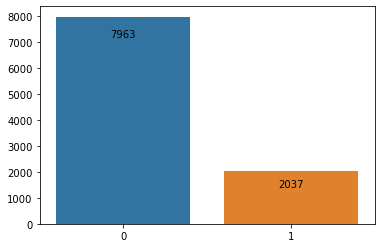

In [42]:
ax = sns.barplot(x = target.value_counts().index, y = target.value_counts().values)
rects = ax.patches
ax.text(
    rects[0].get_x() + rects[0].get_width()/2, rects[0].get_height() * 0.9, target.value_counts().values[0], ha = 'center'
)
ax.text(
    rects[1].get_x() + rects[1].get_width()/2, rects[1].get_height() * 0.7, target.value_counts().values[1], ha = 'center'
)
plt.show()

We see a clear imbalance of classes, customers who have terminated the contract with the bank are much less than those who continue to be serviced by the bank. Accordingly, the previous models had a very small sample for class 1 and much more for class 0, therefore it is more difficult for the model to learn how to predict class 1 correctly, there are several ways to deal with this, firstly, you can set more weight to class 1 objects, respectively, errors in predicting this class will be more significant for the model, secondly, the upsampling method, that is, an artificial increase in the number of objects of class 1, and thirdly, the downsampling method, is an artificial decrease in the number of objects of class 0

## Class weight

### 1. Decision Tree

Let's select the best hyperparameters for the F1 metric

In [43]:
tree_params = {
    'ccp_alpha' : np.arange(0,0.003,0.0005),
    'max_depth' : range(3,20, 3),
    'min_samples_split' : range(2,40,5),
    'min_samples_leaf' : range(1,20,2),
    'class_weight' : ['balanced']
}
grid_weight_tree = GridSearchCV(DecisionTreeClassifier(random_state = 122333),tree_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_weight_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
                         'class_weight': ['balanced'],
                         'max_depth': range(3, 20, 3),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 40, 5)},
             scoring='f1')

In [44]:
tree_parameters = grid_weight_tree.best_params_
print(tree_parameters)

{'ccp_alpha': 0.0015, 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [45]:
metrics_ = get_score_hyperparameters(DecisionTreeClassifier(**grid_weight_tree.best_params_,random_state = 122333), features_train, target_train)
metrics_

{'F1': 0.5709477924710953,
 'Roc_auc': 0.8398107838110699,
 'Accuracy': 0.7725333333333333,
 'Precision': 0.46205390841091,
 'Recall': 0.7481804759423311}

By balancing classes with weights, the Recall metric has improved significantly, the accuracy metric has become a little smaller, but this can be sacrificed for a larger percentage of class 1 identified clients

In [46]:
best_weight_tree_params = tree_parameters
best_weight_tree_model = grid_weight_tree.best_estimator_
models_and_metrics.loc['DecisionTreeClassifierWeight', :] = metrics_

### 2. Random Forest

Let's select the best hyperparameters (without the n_estimators hyperparameter, set it to 20)

In [47]:
forest_params = {
    'ccp_alpha' : np.arange(0,0.002,0.0005),
    'max_depth' : range(5,20, 3),
    'min_samples_split' : range(2,40,5),
    'min_samples_leaf' : range(2,20,3),
    'class_weight' : ['balanced'],
    'n_estimators' : [20]
}
grid_weight_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),forest_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_weight_forest.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015]),
                         'class_weight': ['balanced'],
                         'max_depth': range(5, 20, 3),
                         'min_samples_leaf': range(2, 20, 3),
                         'min_samples_split': range(2, 40, 5),
                         'n_estimators': [20]},
             scoring='f1')

In [48]:
forest_parameters = grid_weight_forest.best_params_
print(forest_parameters)

{'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 20}


Now let's select the hyperparameter n_estimators

In [49]:
new_params = {key : [forest_parameters[key]] for key in forest_parameters}
new_params['n_estimators'] = range(20,150,20)
grid_weight_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),new_params,cv = 5, scoring = 'f1', n_jobs = -1)
grid_weight_forest.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0005], 'class_weight': ['balanced'],
                         'max_depth': [17], 'min_samples_leaf': [2],
                         'min_samples_split': [32],
                         'n_estimators': range(20, 150, 20)},
             scoring='f1')

In [50]:
forest_parameters = grid_weight_forest.best_params_
print(forest_parameters)

{'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 80}


Let's look at the quality of the model

In [60]:
metrics_ = get_score_hyperparameters(RandomForestClassifier(**grid_weight_forest.best_params_, random_state = 122333), features_train, target_train)
metrics_

{'F1': 0.6151061355848229,
 'Roc_auc': 0.8568516965190958,
 'Accuracy': 0.8282666666666666,
 'Precision': 0.5632023947409748,
 'Recall': 0.6789669098488796}

In [61]:
best_weight_forest_params = forest_parameters
best_weight_forest_model = grid_weight_forest.best_estimator_
models_and_metrics.loc['RandomForestClassifierWeight', :] = metrics_

### 3. Logistic Regression

In [62]:
logistic_params = {
    'penalty' : ['l1','l2'],
    'max_iter' : range(50,150,10),
    'solver' : ['liblinear'],
    'class_weight' : ['balanced']
}
grid_weight_logistic = GridSearchCV(LogisticRegression(random_state = 122333),logistic_params,cv = 5, scoring = 'f1', n_jobs = -1)
grid_weight_logistic.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=122333), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_iter': range(50, 150, 10),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

In [63]:
grid_weight_logistic.best_params_

{'class_weight': 'balanced',
 'max_iter': 50,
 'penalty': 'l2',
 'solver': 'liblinear'}

Let's look at the quality of the model

In [64]:
metrics_ = get_score_hyperparameters(LogisticRegression(**grid_weight_logistic.best_params_), features_train, target_train)
metrics_

{'F1': 0.4868819972487004,
 'Roc_auc': 0.766306627302008,
 'Accuracy': 0.7069333333333334,
 'Precision': 0.37691524304392504,
 'Recall': 0.6882186902900818}

In [65]:
best_weight_logistic_params = grid_weight_logistic.best_params_
best_weight_logistic_model = grid_weight_logistic.best_estimator_
models_and_metrics.loc['LogisticRegressionClassifierWeight', :] = metrics_

## Upsampling

To fight with the imbalance of classes, we will try to use upsampling, namely artificially increase the number of objects of class 1

In [66]:
features_train_upsampled, target_train_upsampled = upsampling(features_train, target_train, 
                                    len(target_train[target_train == 0]) // len(target_train[target_train == 1]))

In [67]:
print('Number of objects of class 0', len(target_train_upsampled[target_train_upsampled == 0]))
print('Number of objects of class 1', len(target_train_upsampled[target_train_upsampled == 1]))

Количество объектов 0 класса 5983
Количество объектов 1 класса 4551


### 1. Decision Tree

In [68]:
tree_params = {
    'criterion' : ['gini','entropy'],
    'ccp_alpha' : np.arange(0,0.003,0.0005),
    'max_depth' : range(3,20, 3),
    'min_samples_split' : range(2,40,5),
    'min_samples_leaf' : range(1,20,2)
}
grid_upsampling_tree = GridSearchCV(DecisionTreeClassifier(random_state = 122333),tree_params,cv = 5, scoring = 'f1', n_jobs= -1)
grid_upsampling_tree.fit(features_train_upsampled, target_train_upsampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 20, 3),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 40, 5)},
             scoring='f1')

In [69]:
grid_upsampling_tree.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [107]:
metrics_ = get_score_hyperparameters(DecisionTreeClassifier(**grid_upsampling_tree.best_params_,random_state = 122333), features_train, target_train, True)
metrics_

{'F1': 0.478743299495817,
 'Roc_auc': 0.6741506027307749,
 'Accuracy': 0.7878666666666667,
 'Precision': 0.47655961428533733,
 'Recall': 0.4822754026609678}

In [108]:
best_upsampling_tree_params = grid_upsampling_tree.best_params_
best_upsampling_tree_model = grid_upsampling_tree.best_estimator_
models_and_metrics.loc['DecisionTreeClassifierUpsampling', :] = metrics_

### 2.Random Forest

In [111]:
forest_params = {
    'ccp_alpha' : np.arange(0,0.002,0.0005),
    'max_depth' : range(5,20, 3),
    'min_samples_split' : range(6,40,5),
    'min_samples_leaf' : range(2,20,3),
    'n_estimators' : [20]
}
grid_upsampling_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),forest_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_upsampling_forest.fit(features_train_upsampled, target_train_upsampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015]),
                         'max_depth': range(5, 20, 3),
                         'min_samples_leaf': range(2, 20, 3),
                         'min_samples_split': range(6, 40, 5),
                         'n_estimators': [20]},
             scoring='f1')

In [112]:
best_params = grid_upsampling_forest.best_params_
print(best_params)

{'ccp_alpha': 0.0, 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}


In [113]:
other_params = {key:[best_params[key]] for key in best_params}
other_params['n_estimators'] = range(20,150,10)
grid_upsampling_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),other_params,cv = 5, scoring = 'f1', n_jobs = -1)
grid_upsampling_forest.fit(features_train_upsampled, target_train_upsampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0], 'max_depth': [17],
                         'min_samples_leaf': [2], 'min_samples_split': [6],
                         'n_estimators': range(20, 150, 10)},
             scoring='f1')

In [114]:
metrics_ = get_score_hyperparameters(RandomForestClassifier(**grid_upsampling_forest.best_params_,random_state = 122333), features_train, target_train, True)
print(metrics_)

{'F1': 0.6036569701038649, 'Roc_auc': 0.849426948547871, 'Accuracy': 0.8474666666666668, 'Precision': 0.6365293929524596, 'Recall': 0.5757309284618344}


In [115]:
best_upsampling_forest_params = grid_upsampling_forest.best_params_
best_upsampling_forest_model = grid_upsampling_forest.best_estimator_
models_and_metrics.loc['RandomForestClassifierUpsampling', :] = metrics_

### 3. Logistic Regression

In [116]:
logistic_params = {
    'penalty' : ['l1','l2'],
    'max_iter' : range(50,150,10),
    'solver' : ['liblinear']
}
grid_upsampling_logistic = GridSearchCV(LogisticRegression(random_state = 122333),logistic_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_upsampling_logistic.fit(features_train_upsampled, target_train_upsampled)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=122333), n_jobs=-1,
             param_grid={'max_iter': range(50, 150, 10),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

In [117]:
grid_upsampling_logistic.best_params_

{'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}

In [118]:
metrics_ = get_score_hyperparameters(LogisticRegression(**grid_upsampling_logistic.best_params_), features_train, target_train, True)
metrics_

{'F1': 0.4903166508366142,
 'Roc_auc': 0.7665642317748611,
 'Accuracy': 0.7516,
 'Precision': 0.41994032480459076,
 'Recall': 0.5916684472439786}

In [119]:
best_upsampling_logistic_params = grid_upsampling_logistic.best_params_
best_upsampling_logistic_model = grid_upsampling_logistic.best_estimator_
models_and_metrics.loc['LogisticRegressionUpsampling', :] = metrics_

## Downsampling

Reduce the number of objects of the prevailing class in the training sample to combat the imbalance

In [120]:
features_train_downsampling,target_train_downsampling = downsampling(features_train, target_train, len(target_train[target_train == 1]))

In [121]:
print('Number of objects of class 0:', len(target_train_downsampling[target_train_downsampling == 0]))
print('Number of objects of class 1:', len(target_train_downsampling[target_train_downsampling == 1]))

Количество объектов класса 0: 1517
Количество объектов класса 1: 1517


### 1.Decision Tree

In [122]:
tree_params = {
    'ccp_alpha' : np.arange(0,0.003,0.0005),
    'max_depth' : range(3,20, 3),
    'min_samples_split' : range(2,40,4),
    'min_samples_leaf' : range(1,20,2)
}
grid_downsampling_tree = GridSearchCV(DecisionTreeClassifier(random_state = 122333),tree_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_downsampling_tree.fit(features_train_downsampling, target_train_downsampling)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
                         'max_depth': range(3, 20, 3),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 40, 4)},
             scoring='f1')

In [123]:
grid_downsampling_tree.best_params_

{'ccp_alpha': 0.0025,
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [146]:
metrics_ = get_score_hyperparameters(DecisionTreeClassifier(**grid_downsampling_tree.best_params_, random_state = 122333), features_train, target_train, downsampling=True)
metrics_

{'F1': 0.5395595404294034,
 'Roc_auc': 0.8267574165356748,
 'Accuracy': 0.7408,
 'Precision': 0.4260875973920005,
 'Recall': 0.7505867106636419}

In [147]:
best_downsampling_tree_params = grid_downsampling_tree.best_params_
best_downsampling_tree_model = grid_downsampling_tree.best_estimator_
models_and_metrics.loc['DecisionTreeClassifierDownsampling', :] = metrics_

### 2. Random Forest

In [126]:
forest_params = {
    'ccp_alpha' : np.arange(0,0.002,0.0005),
    'max_depth' : range(5,20, 3),
    'min_samples_split' : range(6,40,5),
    'min_samples_leaf' : range(2,20,3),
    'n_estimators' : [20]
}
grid_downsampling_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),forest_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_downsampling_forest.fit(features_train_downsampling, target_train_downsampling)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015]),
                         'max_depth': range(5, 20, 3),
                         'min_samples_leaf': range(2, 20, 3),
                         'min_samples_split': range(6, 40, 5),
                         'n_estimators': [20]},
             scoring='f1')

In [127]:
best_params = grid_downsampling_forest.best_params_
print(best_params)

{'ccp_alpha': 0.0005, 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 20}


In [128]:
other_params = {key:[best_params[key]] for key in best_params}
other_params['n_estimators'] = range(20,150,10)
grid_downsampling_forest = GridSearchCV(RandomForestClassifier(random_state = 122333),other_params,cv = 5, scoring = 'f1', n_jobs = -1)
grid_downsampling_forest.fit(features_train_downsampling, target_train_downsampling)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=122333),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0005], 'max_depth': [17],
                         'min_samples_leaf': [2], 'min_samples_split': [16],
                         'n_estimators': range(20, 150, 10)},
             scoring='f1')

In [129]:
metrics_ = get_score_hyperparameters(RandomForestClassifier(**grid_downsampling_forest.best_params_,random_state = 122333), features_train, target_train, downsampling=True)
print(metrics_)

{'F1': 0.5883137697119982, 'Roc_auc': 0.8517242521257945, 'Accuracy': 0.7864, 'Precision': 0.48398109857875865, 'Recall': 0.7547145339433058}


In [130]:
best_downsampling_forest_params = grid_downsampling_forest.best_params_
best_downsampling_forest_model = grid_downsampling_forest.best_estimator_
models_and_metrics.loc['RandomForestClassifierDownsampling', :] = metrics_

### 3. Logistic Regression

In [131]:
logistic_params = {
    'penalty' : ['l1','l2'],
    'max_iter' : range(50,150,10),
    'solver' : ['liblinear']
}
grid_downsampling_logistic = GridSearchCV(LogisticRegression(random_state = 122333),logistic_params,cv = 5, scoring = 'f1', n_jobs=-1)
grid_downsampling_logistic.fit(features_train_downsampling, target_train_downsampling)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=122333), n_jobs=-1,
             param_grid={'max_iter': range(50, 150, 10),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

In [132]:
grid_downsampling_logistic.best_params_

{'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}

In [133]:
metrics_ = get_score_hyperparameters(LogisticRegression(**grid_downsampling_logistic.best_params_), features_train, target_train,downsampling=True)
metrics_

{'F1': 0.48752338211178897,
 'Roc_auc': 0.7663819477034316,
 'Accuracy': 0.7062666666666667,
 'Precision': 0.376955986377471,
 'Recall': 0.6917004815269532}

In [134]:
best_downsampling_logistic_params = grid_downsampling_logistic.best_params_
best_downsampling_logistic_model = grid_downsampling_logistic.best_estimator_
models_and_metrics.loc['LogisticRegressionDownsampling', :] = metrics_

## Model selection

Let's choose the best final model from the previously considered ones, for this we will analyze the metrics of the models obtained as a result of cross-validation

In [148]:
models_and_metrics = models_and_metrics.astype('float')
models_and_metrics.style.background_gradient('Greens',axis = 0).format("{:.4}")

,F1,Roc_auc,Accuracy,Precision,Recall
DecisionTreeClassifier,0.5723,0.8378,0.8544,0.7043,0.4832
RandomForestClassifier,0.568,0.8498,0.8629,0.7832,0.4456
LogisticRegression,0.2963,0.7636,0.8103,0.5923,0.1978
DecisionTreeClassifierWeight,0.5709,0.8398,0.7725,0.4621,0.7482
RandomForestClassifierWeight,0.6151,0.8569,0.8283,0.5632,0.679
LogisticRegressionClassifierWeight,0.4869,0.7663,0.7069,0.3769,0.6882
DecisionTreeClassifierUpsampling,0.4787,0.6742,0.7879,0.4766,0.4823
RandomForestClassifierUpsampling,0.6037,0.8494,0.8475,0.6365,0.5757
LogisticRegressionUpsampling,0.4903,0.7666,0.7516,0.4199,0.5917
DecisionTreeClassifierDownsampling,0.5396,0.8268,0.7408,0.4261,0.7506


The leading models are RandomForestClassifierUpsampling, RandomForestClassifierWeight, all of them have the F1 metric we are interested in more than 0.6 and all of them have taken measures to fight with class imbalance for training. As we can see, logistic regression basically always shows worse results compared to a random forest and a decision tree, except perhaps a decision tree with the upsampling method, the max_depth parameter that was chosen there is quite large, so it probably shows that the tree model has been retrained. The forest also generally shows better results than the decision tree, which is quite logical, since the forest itself consists of decision trees.

In [151]:
models_and_metrics[models_and_metrics['F1'] >= 0.6].style.background_gradient('Greens',axis = 0).format("{:.4}")

,F1,Roc_auc,Accuracy,Precision,Recall
RandomForestClassifierWeight,0.6151,0.8569,0.8283,0.5632,0.679
RandomForestClassifierUpsampling,0.6037,0.8494,0.8475,0.6365,0.5757


The selected model is RandomForestClassifierWeight, since the most important indicators - F1, Recall and ROC-AUC are collectively better than the other model, while the remaining metrics are also quite high

## Testing the model

In [152]:
print('F1 =',f1_score(target_test, best_weight_forest_model.predict(features_test)))
print('Roc-auc = ', roc_auc_score(target_test, best_weight_forest_model.predict_proba(features_test)[:,1]))

F1 = 0.6382978723404255
Roc-auc =  0.8620794483294484


The resulting quality metrics on the test sample turned out to be quite good, the goal to achieve F1-score > 0.59 is fulfilled. As we can see, the result turned out to be even higher than the f1-score on cross-validation, probably because during cross-validation the score was considered as an arithmetic mean, so perhaps due to poor quality at some iteration the score turned out to be less

## Conclusion

The model we have chosen to solve the problem is RandomForestClassifier using balanced class weighting to fight with the imbalance, on the test sample the obtained model metrics = F1 : 0.638, AUC-ROC : 0.862, the model has the following hyperparameters:

In [153]:
best_weight_forest_params

{'ccp_alpha': 0.0005,
 'class_weight': 'balanced',
 'max_depth': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 32,
 'n_estimators': 80}